# A notebook to calculate ECFMs for a small community model
Elementary community flux modes (ECFMs) are calculated by <a href="https://pypi.org/project/efmtool/">efmtool</a> from a full community matrix or matrix projected to exchange fluxes and microbe mass fractions. The input matrix can be created manually as a numpy array or by importing SBML file created with <a href="https://doi.org/10.1093/bioinformatics/btae153">PyCoMo</a> using cobrapy.


In [1]:
import efmtool
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## General functions

In [2]:
def run_efmtool(matrix, rxn_names, met_names, revs=[]):
    """
    run efmtool and return numpy array with fluxes
    Args:
        matrix: numpy array with the stoichiometric matrix
        rxn_names: list of reaction names
        met_names: list of metabolite names
        revs: list of reversibilities (0 irreversible / 1 reversible). 
            If not provided, all reactions are assumed to be irreversible.
    Returns:
        pandas data frame with EFMs as rows and reactions as columns
    """

    options = efmtool.get_default_options()
    options["arithmetic"] = "fractional"
    options['level'] = 'WARNING'

    # if reversibilities not provided, assume all reactions irreversible
    if not revs:
        revs = reversibilities = [0]*matrix.shape[1]
    modes = efmtool.calculate_efms(stoichiometry = matrix,
                                   reversibilities = revs,
                                   reaction_names = rxn_names,
                                   metabolite_names = met_names,
                                   options = options)

    nice_modes = make_nice_results(modes, rxn_names)
    
    return nice_modes

In [3]:
def make_nice_results(modes, rxn_names):
    """
    Convert array from efmtool into a nice pandas DataFrame
    Args:
        modes: numpy array with the output of "efmtool.calculate_efms()"
        rxn_names: list of reaction names
    Returns:
        pandas data frame with EFMs as rows and reactions as columns
    """

    # if there are no columns - no modes
    if modes.shape[1] == 0:
        return pd.DataFrame()

    # solve "ValueError: Big-endian buffer not supported on little-endian compiler"
    # modes = modes.byteswap().newbyteorder()

    res = pd.DataFrame(modes.T,
                       index = [f"Mode{(i+1)}" for i in range(modes.shape[1])],
                       columns = rxn_names)

    # normalize values by the column C
    if "C" in res.columns:
        res = res.div(res.C, axis = 0)

    return res

In [4]:
def community_matrix_sbml(cobra_model, organism_ids, mu=1):
    """
    Extracts stoichiometric matrix, and lists of reaction IDs, metabolite IDs 
    and reversibilities from a cobra model. Adds bounds on growth rate and the
    total sum of microbe fractions=1

    Args:
        cobra_model: cobrapy Model object created with PyCoMo
        organism_ids: list of organism names used in the cobra model
        mu: growth rate to set
    Returns:
        N: numpy array with the stoichiometric matrix formatted for the use with efmtool
        rxns: list of reaction names
        mets: list of metabolite names
        revs: list of reversibilities (0 irreversible / 1 reversible)
        """
    N = cobra.util.array.create_stoichiometric_matrix(cobra_model)
    rxns = [r.id for r in cobra_model.reactions]
    mets = [m.id for m in cobra_model.metabolites]
    revs = []
    for index, r in enumerate(cobra_model.reactions):
        if r.lower_bound < 0:
            if r.reversibility:
                revs.append(1)
            # flip irreversible reactions that only go in reverse direction
            if not r.reversibility:
                N[:, index] = -N[:, index]
                revs.append(0)
        else:
            revs.append(0)

    N, rxns, mets, revs = add_bounds_to_pycomo_matrix(N, rxns, mets, revs, mu, organism_ids)

    return (N, rxns, mets, revs)

In [5]:
def add_bounds_to_pycomo_matrix(N, rxns, mets, revs, mu, member_names):
    """
    Adds constraints to stoichiometric matrix extracted from PyCoMo model
    * sum of microbe fractions = 1 -> set the value of reaction "f_final" to 1
    * set growth rate -> 
        set flux of "community_biomass" to mu 
        update stoichiometry of "{member}_f_biomass_met" in "{member}_fraction_reaction" to mu
    Args:
        N: numpy array with the stoichiometric matrix extracted with cobrapy.
            Note - irreversible reactions must be defined in the forward direction
        rxns: list of reaction names
        mets: list of metabolite names
        revs: list of reversibilities (0 irreversible / 1 reversible)
        mu: growth rate
        member_names: list of organism names in the PyCoMo model
    Returns:
        N2: numpy array with the stoichiometric matrix formatted for the use with efmtool
        rxns2: list of reaction names
        mets2: list of metabolite names
        revs2: list of reversibilities (0 irreversible / 1 reversible)
    
    """
    rxns2 = rxns + ["C"]
    revs2 = revs + ["0"]
    mets2 = mets + ["gamma", "mu"]

    # add column for equality constraints
    N2 = np.hstack([N, np.zeros((N.shape[0], 1))])

    # add rows with new constraints
    gamma_constraint = []  # fractions must sum up to 1
    gamma_values = {"f_final": 1, "C": -1}

    mu_constraint = []  # constraint on growth rate
    mu_values = {"community_biomass": 1, "C": -mu}

    for reaction in rxns2:
        gamma_constraint.append(gamma_values.get(reaction, 0))
        mu_constraint.append(mu_values.get(reaction, 0))

    N2 = np.vstack([N2, gamma_constraint, mu_constraint])
    
    # update stoichiometry to change growth rate
    for member in member_names:
        j = rxns2.index(f"{member}_fraction_reaction")
        i = mets2.index(f"{member}_f_biomass_met")
        N2[i, j] = mu
    
    return N2, rxns2, mets2, revs2

In [6]:
def update_pycomo_growth_rate(N, rxns, mets, mu, member_names):
    """
    Set growth rate of PyCoMo model - 
        * set flux of "community_biomass" to mu,
        * update stoichiometry of "{member}_f_biomass_met" in "{member}_fraction_reaction" to mu
    Args: 
        N: numpy array with the PyCoMo stoichiometric matrix preformatted with
            "add_bounds_to_pycomo_matrix()"
        rxns: list of reaction names
        mets: list of metabolite names
        mu: growth rate
        member_names: list of organism names in the PyCoMo modes
    Returns:
        None
    """
    for member in member_names:
        j = rxns.index(f"{member}_fraction_reaction")
        i = mets.index(f"{member}_f_biomass_met")
        N[i, j] = mu

    N[mets.index("mu"), rxns.index("C")] = -mu

In [7]:
def scan_growth_rates(mus, rxn_ids, N, rxns, mets, revs, member_names):
    """
    Get minimum and maximum values for specified reactions for a range of growth rates
    using the PyCoMo matrix
    Args:
        mus: array of growth rates to test
        rxn_ids: reaction ids to collect
        N: numpy array with the stoichiometric matrix formatted with "add_bounds_to_pycomo_matrix()"
        rxns: list of reaction names
        mets: list of metabolite names
        revs: list of reversibilities (0 irreversible / 1 reversible)
        member_names: list of organism names in the PyCoMo modes
    Returns:
        feasible_mus: list of mus for which solution exists
        all_mins, all_maxs: dictionaries with minimum and maximum fluxes with rxn_ids as keys 
    """
    feasible_mus = []
    all_mins = {}
    all_maxs = {}
    
    for mu in mus:
        update_pycomo_growth_rate(N, rxns, mets, mu, member_names)
        efms = run_efmtool(N, rxns, mets, revs)
    
        if not efms.empty:
            for one_id in rxn_ids:
                try:
                    all_mins[one_id].append(efms[one_id].min())
                    all_maxs[one_id].append(efms[one_id].max())
                except KeyError:
                    all_mins[one_id] = [efms[one_id].min()]
                    all_maxs[one_id] = [efms[one_id].max()]

            feasible_mus.append(mu)

    return feasible_mus, all_mins, all_maxs


In [8]:
def plot_projected_compositions(mus, gmins, gmaxes, vmins, vmaxes, ecfms):
    """
    plot community compositions and uptakes as a function of growth rate
    Args:
        mus - list of growth rates to plot
        gmins, gmaxes - lists of min and max gammas
        vmins, vmaxes - lists of min and max uptakes
        ecfms - dictionary of ecfms to plot with growth rates as keys and
        a tuple with two lists (gammas and uptakes) as values.
    """
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))  # 1 row, 2 columns
    size = 14
    uni_blue = "#0063a6"

    # First plot
    axs[0].fill_between(mus, gmins, gmaxes, color=uni_blue)
    axs[0].set_xlabel("Growth rate", size=size)
    axs[0].set_ylabel("Abundance of microbe 1", size=size)
    axs[0].set_title("Projected compositions", size=size)
    
    # Second plot
    axs[1].fill_between(mus, vmins, vmaxes, color=uni_blue)
    axs[1].set_xlabel("Growth rate", size=size)
    axs[1].set_ylabel("Uptake of microbe 1", size=size)
    axs[1].set_title("Projected uptakes", size=size)

    for mu, ecx in ecfms.items():
        mu = float(mu)
        axs[0].scatter([mu]*len(ecx[0]), ecx[0], color="orange", s=30)
        axs[1].scatter([mu]*len(ecx[1]), ecx[1], color="orange", s=30)
    
    plt.tight_layout()
    plt.show()

## Model 1

<div style="display: flex; gap: 20px; align-items: flex-start;">
  <img src="model1.png" alt="Model 1" style="width: 250px;" />

  <div style="text-align: center;">
    <h3>Full Matrix</h3>
    <img src="full_matrix.png" alt="Full Matrix" style="width: 400px;" />
  </div>

  <div style="text-align: center;">
    <h3>Projected Matrix</h3>
    <img src="projected_matrix.png" alt="Projected Matrix" style="width: 350px;" />
  </div>
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> efmtool does not accept inequalities, so we need to add slack variables. For each inequality constraint there is a new column (labelled S[n]) with 1 for $\leq$ and -1 for $\geq$.  There is also an extra equality constraint for $\gamma 1 + \gamma2 = 1$ which adds a new row and also a column (labelled C).
</div>.

In [9]:
def community_matrix_full(mu, u1=1, u2=1):
    """full stoichiometric matrix of the community"""
    N = np.array(
        [[-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
         [ 0, -1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0],
         [ 0,  0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
         [ 1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  1,  1,-mu,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,-mu,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1,  0,  0,  0,  0,-u1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,-u2,  0,  0,  0,  0,  0,  1,  0],
         [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, -1]]
    )

    met_names = ["X1", "X2", "Y1", "Y2",
                 "S1", "B1", "P1", "A1",
                 "S2", "B2", "P2", "A2",
                 "v1", "v2", "gamma"]
    rxn_names = ["v11", "v12", "v13", "v14", "v15", "g1",
                 "v21", "v22", "v23", "v24", "v25", "g2",
                 "S1", "S2", "S3", "S4", "S5", "S6", "C"]

    return (N, rxn_names, met_names)

In [10]:
def community_matrix_projected(mu, u1=1, u2=1):
    """community stoichiometric matrix projected to exchage fluxes and composition"""
    N = np.array(
        [[0, -1,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0],
         [0,  0,  1,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0],
         [1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [1,  1,  0,-mu,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0],
         [0,  0,  0,  0,  1,  1,  0,-mu,  0,  0,  0,  0,  0],
         [1,  0,  0,-u1,  0,  0,  0,  0,  0,  0,  1,  0,  0],
         [0,  0,  0,  0,  1,  0,  0,-u2,  0,  0,  0,  1,  0],
         [0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0, -1]])
    rxn_names = ["v11", "v12","v13","g1","v21","v22","v23","g2","S1","S2","S3","S4","C"]
    met_names = ["Y1","Y2","S1P1","S1B1A1","S2P2","S2B2A2","v11","v21","gamma"]
    return (N, rxn_names, met_names)

In [11]:
# IDs of abundance reactions and transport reactions
projected_ids = ["g1","g2","v11","v12","v13","v21","v22","v23"]

In [12]:
# community matrix from SBML file from PyCoMo
model = cobra.io.read_sbml_model("com_model_toy_fixed_growth.xml")
model.reactions.remove("abundance_reaction")  # remove reaction for fixing composition
# IDs of abundance reactions and transport reactions
projected_ids_sbml = ["org1_fraction_reaction", "org2_fraction_reaction",
                      "org1_TP_X1", "org1_TP_Y1", "org1_TP_Y2", 
                      "org2_TP_X2", "org2_TP_Y2", "org2_TP_Y1"]
organism_ids = ["org1", "org2"]

### ECFMs for mu = 1

In [13]:
mu = 1

#### from projected matrix - 4 ECFMs

In [14]:
ecfms1_a = run_efmtool(*community_matrix_projected(mu))
ecfms1_a[projected_ids]

,g1,g2,v11,v12,v13,v21,v22,v23
Mode1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
Mode2,0.5,0.5,0.0,0.5,0.0,0.5,0.0,0.5
Mode3,0.5,0.5,0.5,0.0,0.5,0.0,0.5,0.0
Mode4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


#### from full matrix - 4 ECFMs

In [15]:
ecfms1_b = run_efmtool(*community_matrix_full(mu))
ecfms1_b.shape[0]

4

In [16]:
ecfms1_b[projected_ids]

,g1,g2,v11,v12,v13,v21,v22,v23
Mode1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
Mode2,0.5,0.5,0.0,0.5,0.0,0.5,0.0,0.5
Mode3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
Mode4,0.5,0.5,0.5,0.0,0.5,0.0,0.5,0.0


#### from SBML PyCoMo matrix 4 ECFMs

In [17]:
ecfms1_c = run_efmtool(*community_matrix_sbml(model, organism_ids, mu))
ecfms1_c.shape[0]

4

In [18]:
ecfms1_c[projected_ids_sbml]

,org1_fraction_reaction,org2_fraction_reaction,org1_TP_X1,org1_TP_Y1,org1_TP_Y2,org2_TP_X2,org2_TP_Y2,org2_TP_Y1
Mode1,0.5,0.5,0.5,0.0,0.5,0.0,0.5,0.0
Mode2,0.5,0.5,0.0,0.5,0.0,0.5,0.0,0.5
Mode3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
Mode4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### ECXs for mu = 2

In [19]:
mu = 2

#### from projected matrix - 1 ECFM

In [20]:
ecfms2_a = run_efmtool(*community_matrix_full(mu))
ecfms2_a[projected_ids]

,g1,g2,v11,v12,v13,v21,v22,v23
Mode1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


#### from full matrix - 1 ECFM

In [21]:
ecfms2_b = run_efmtool(*community_matrix_full(mu))
ecfms2_b[projected_ids]

,g1,g2,v11,v12,v13,v21,v22,v23
Mode1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


#### from SBML PyCoMo matrix - 1 ECFM

In [22]:
ecfms2_c = run_efmtool(*community_matrix_sbml(model, organism_ids, mu))
ecfms2_c[projected_ids_sbml]

,org1_fraction_reaction,org2_fraction_reaction,org1_TP_X1,org1_TP_Y1,org1_TP_Y2,org2_TP_X2,org2_TP_Y2,org2_TP_Y1
Mode1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


### Space of possible compositions and uptakes calculated with SBML PyCoMo matrix

In [23]:
mus = np.concatenate(([0, 0.5], np.arange(1, 2, 0.1), [2]))

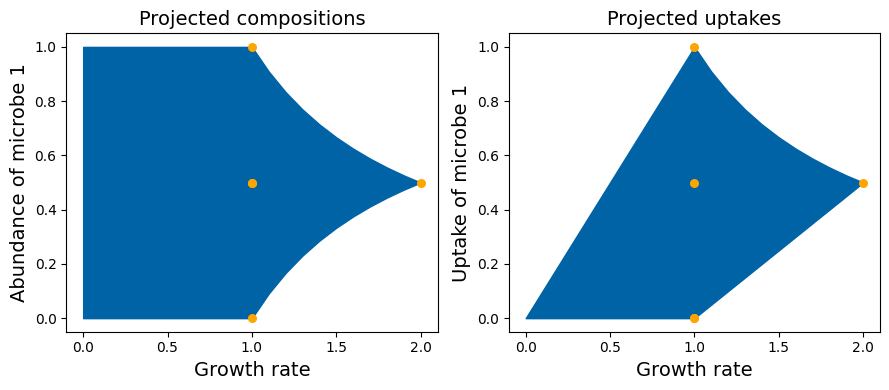

In [24]:
gamma_rxn_id = "org1_fraction_reaction"
uptake_rxn_id = "org1_TP_X1"

ecxs = {"1.0": (ecfms1_c[gamma_rxn_id], ecfms1_c[uptake_rxn_id]),
        "2.0": (ecfms2_c[gamma_rxn_id], ecfms2_c[uptake_rxn_id])}
N, rxns, mets, revs = community_matrix_sbml(model, organism_ids)
feasible_mus, all_mins, all_maxs = scan_growth_rates(mus, 
                                                     [gamma_rxn_id, uptake_rxn_id],
                                                     N, rxns, mets, revs, organism_ids)
plot_projected_compositions(feasible_mus,
                            all_mins[gamma_rxn_id], 
                            all_maxs[gamma_rxn_id], 
                            all_mins[uptake_rxn_id], 
                            all_maxs[uptake_rxn_id],                     
                            ecxs)

The blue areas represent the space of all possible compositions and uptake behaviours. The yellow points are ECFMs calculated for growth rates 1 and 2. 